## Lutfen bu linke git:
https://nbviewer.jupyter.org/github/selimonat/ornament_symmgroups/blob/master/CorrelationAnalysis.ipynb

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from geopy.geocoders import Nominatim
from geopy.distance import geodesic


from sklearn.datasets import load_digits
from sklearn import manifold

from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

import folium


In [61]:
symm_df = pd.read_excel("./symm_groups.xlsx",index_col=0)
symm_df = symm_df.iloc[:,[0,3,2,1,4]]
symm_df

,Andalusia,Armenian,Eastern Roman,ME Arabs,Seljuks
p1,0.970,0.8,14.04,0.000,0.27
p1m1,0.000,4.9,9.65,0.000,0.00
p1g1,0.000,0.0,0.88,0.000,0.00
c1m1,0.000,2.4,4.39,0.000,0.55
p211,0.970,0.0,2.63,3.600,1.10
p2mm,1.942,5.7,9.65,5.778,8.79
p2mg,0.000,0.8,5.26,0.442,0.82
p2gg,0.000,0.8,0.88,0.000,0.55
c2mm,1.942,1.6,3.51,12.890,8.52
p3,0.970,0.8,0.00,0.000,0.82


# Histograms

<IPython.core.display.Javascript object>


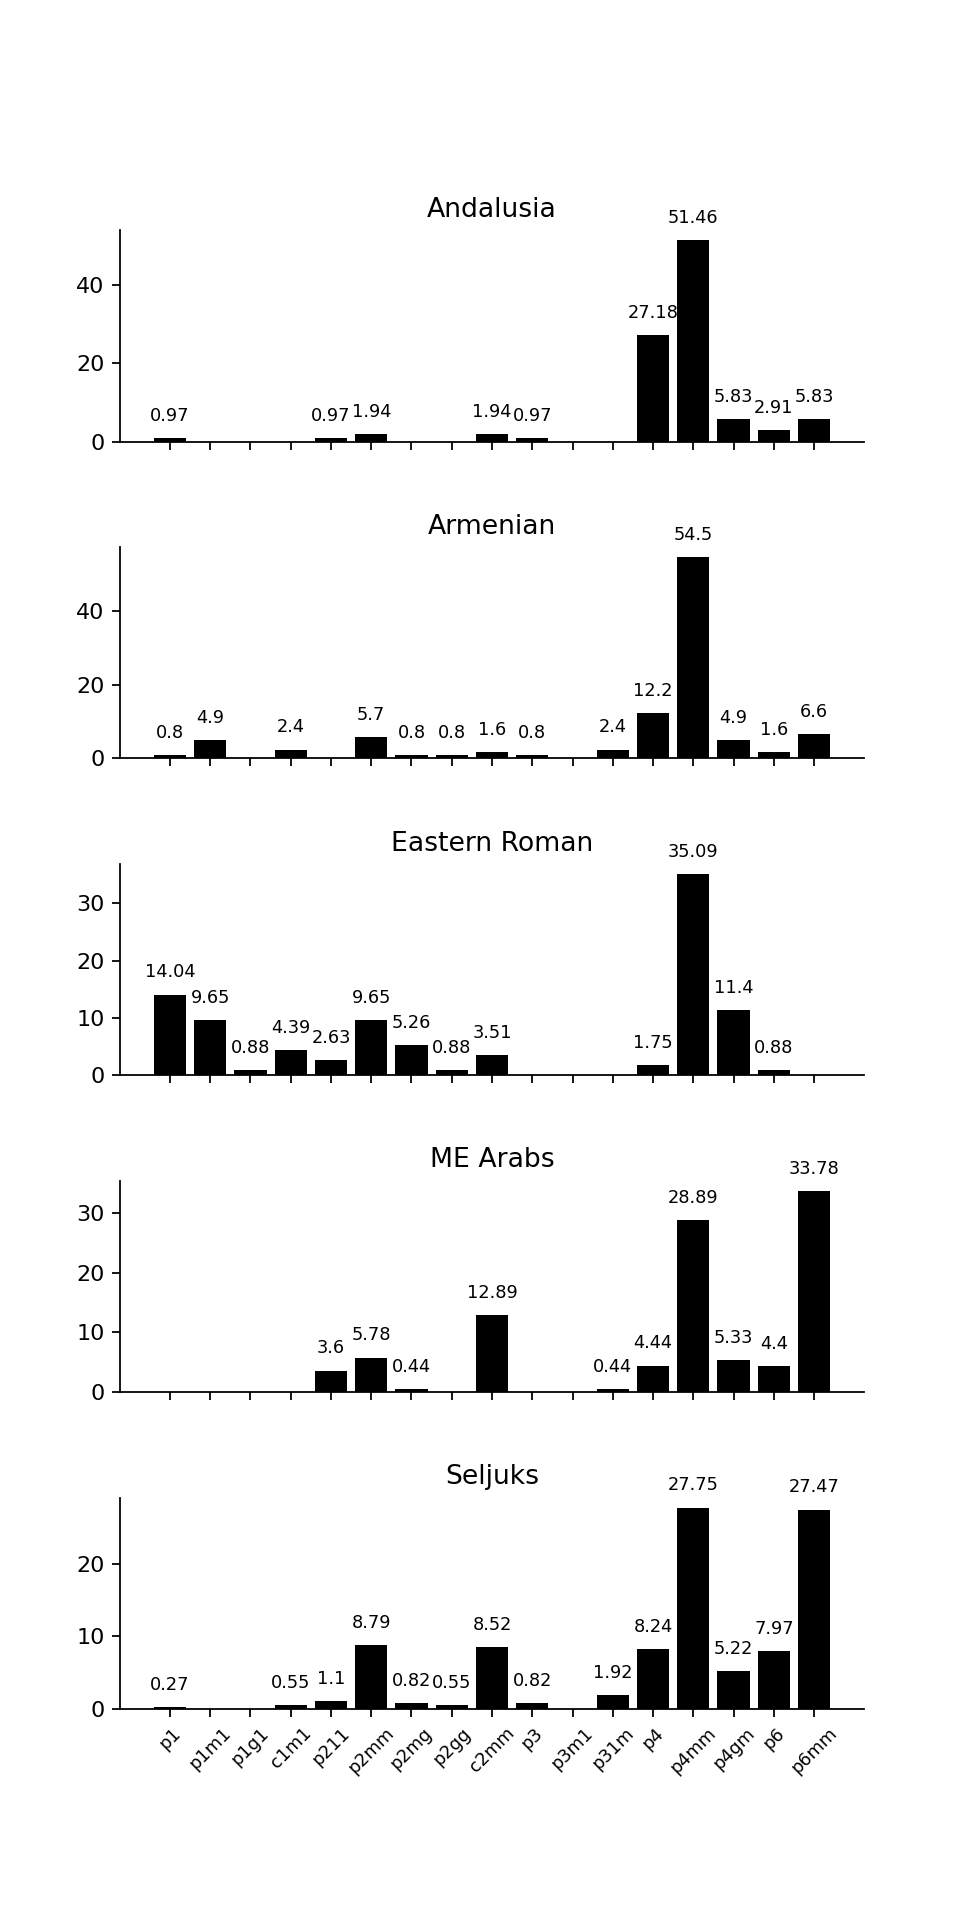

In [62]:
%matplotlib notebook
fig, ax = plt.subplots(5,1,figsize=(6,12))
cols = symm_df.columns.to_list() 
for i in [0,1,2,3,4]:
    ax[i].bar(range(0,17),symm_df[cols[i]],color='k')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    if i is 4:
        ax[i].set_xticklabels(symm_df.index.to_list(),rotation=45,fontsize=8)
    else:
        ax[i].set_xticklabels('')
    ax[i].set_xticks(np.arange(symm_df.shape[0]))
    for p in ax[i].patches:
        if np.ceil(p.get_height()) != 0:
            ax[i].annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=8)
    ax[i].set_title(cols[i])
plt.subplots_adjust(hspace=.5)

# Correlation

<IPython.core.display.Javascript object>


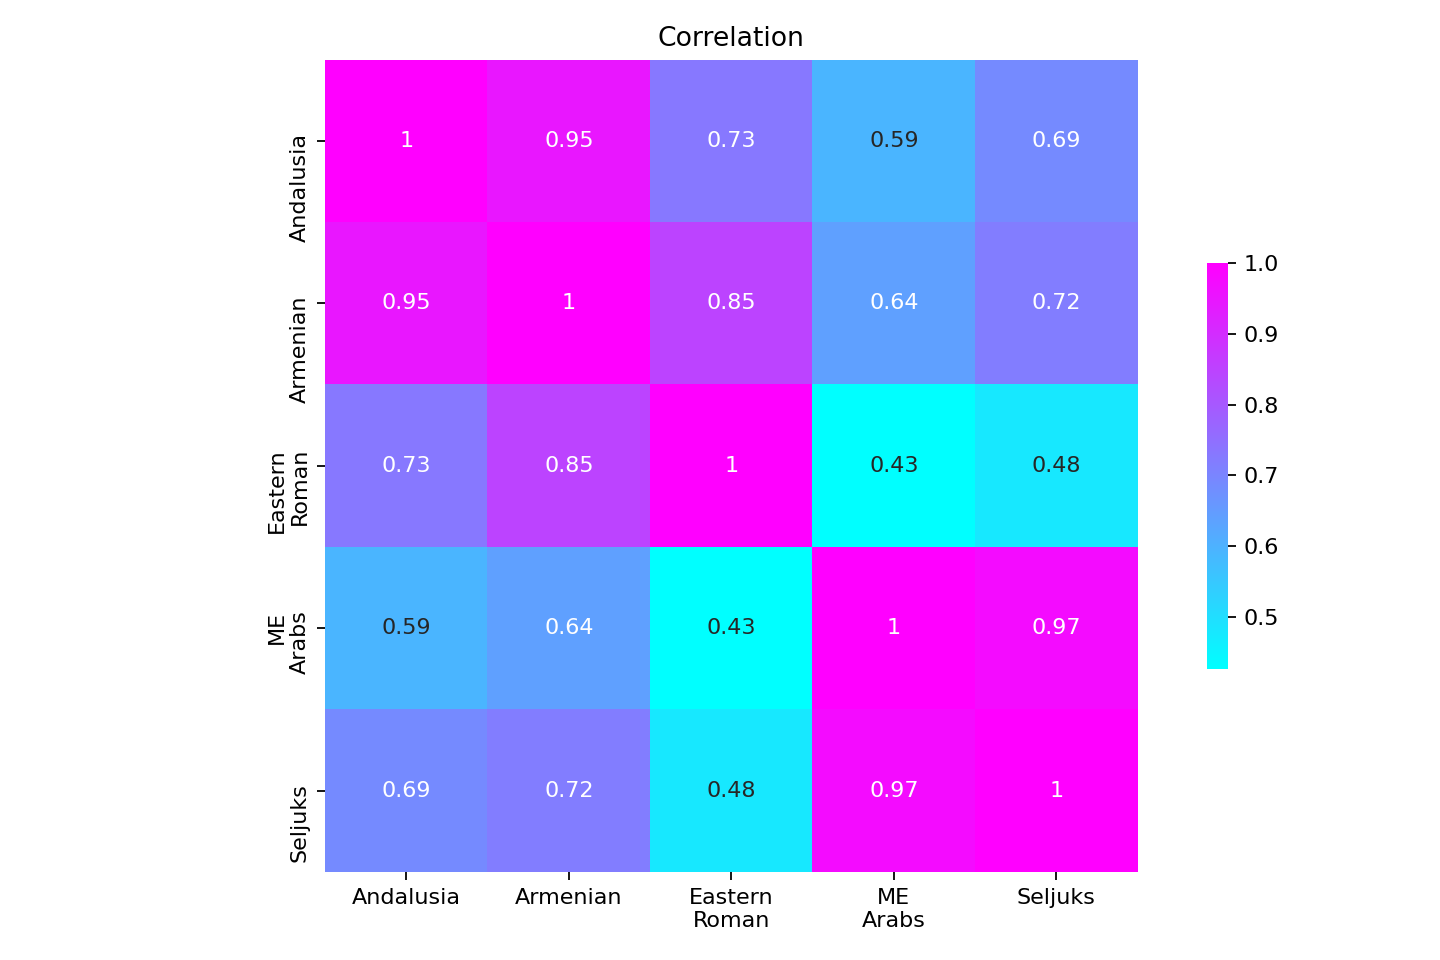

In [63]:
def correlation_panel(df,ax,input_is_corr=False):
    if input_is_corr is False:
        # calculate the correlation matrix    
        corr = df.corr()
    elif input_is_corr is True:
        corr = df
    # plot the heatmap
    sns.heatmap(corr, 
            xticklabels=corr.columns.str.replace(' ','\n'),
            yticklabels=corr.columns.str.replace(' ','\n'),
            cmap='cool',
            square=True,
            ax=ax,
            cbar_kws={"shrink": 0.5},
            annot=corr.values)
    ax.set_title('Correlation')
    plt.tight_layout()
    #biraz deli bir renk oldu ama simdilik kalsin.
    
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
correlation_panel(symm_df,ax=ax)

# MDS 

## MDS analysis takes as input a distance matrix (for example a correlation matrix) and aims to recovers the coordinates that could have potentially generated these dissimilarities.


## The first MDS analysis is done using the geographical distance matrix (as a sanity check). If the algorithm works correctly, MDS should recover the geographical positions of these cities on 2-d, like in a map.

# with Geographical Distances (test case)

In [64]:
#bunlari medeniyetlerin baskenti olarak aldim.
capitals = ['Granada','Yerevan','Venice','Cairo','Konya']
# capitals = ['Paris','Madrid','Rome','Berlin']

@memory.cache
def get_geo_distances():
    geolocator = Nominatim(user_agent="bla")
    Distance = np.zeros((len(capitals),len(capitals)))
    for i,c1 in enumerate(capitals):
        for j,c2 in enumerate(capitals):
            l1 = geolocator.geocode(c1)
            l2 = geolocator.geocode(c2)
            d = geodesic(l1.point, l2.point).km
            Distance[i,j] = d
    return Distance

Distance = get_geo_distances()

<IPython.core.display.Javascript object>


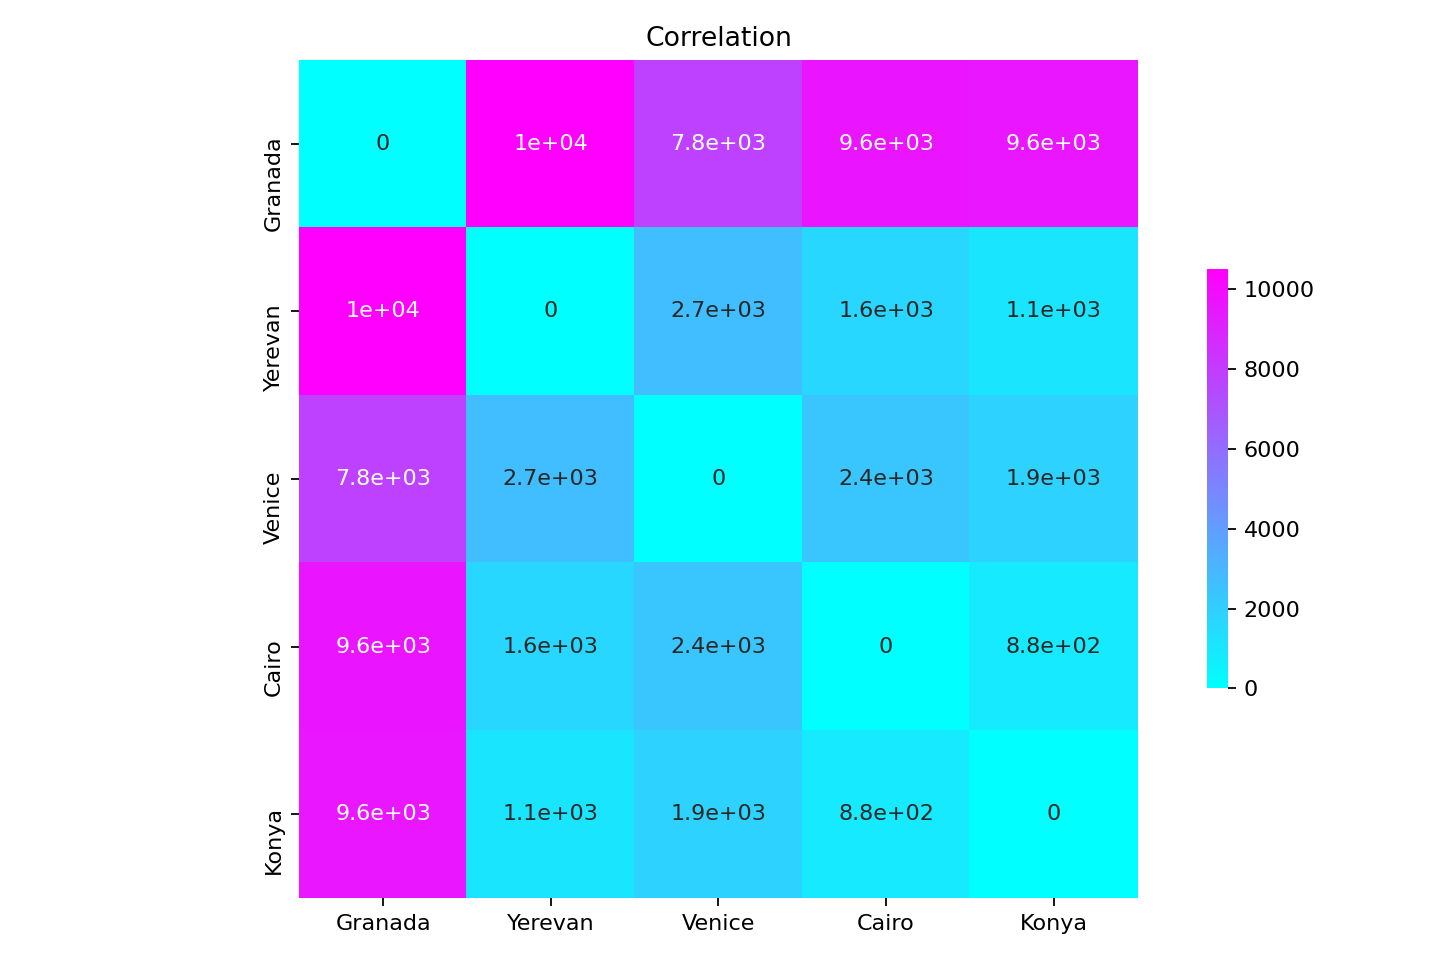

In [65]:
distance_df = pd.DataFrame(Distance)
distance_df.columns = capitals

fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,1)
correlation_panel(distance_df,ax=ax,input_is_corr=True)

<IPython.core.display.Javascript object>


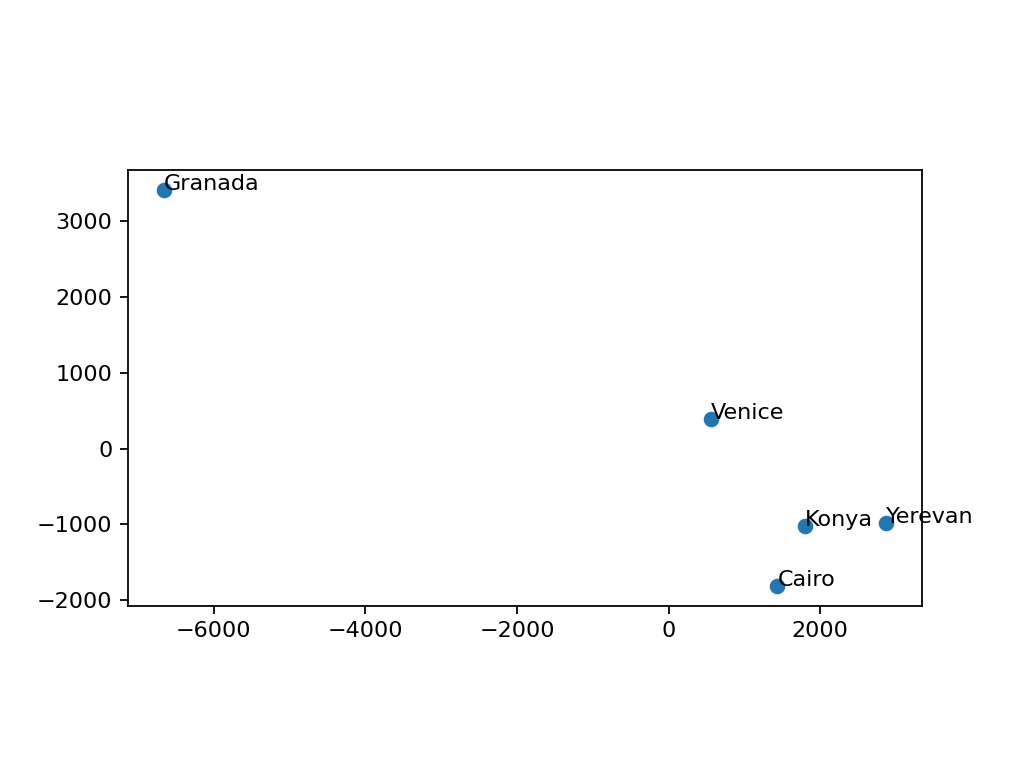

In [66]:
# MDS on geographical distances

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(Distance).embedding_
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.plot(-pos[:,0],pos[:,1],'o')
for i, txt in enumerate(capitals):
    ax.annotate(txt, (-pos[i,0], pos[i,1]))
    
# I would say it works. Let's do the MDS with symmetri distances

In [67]:
def MDS_panel(ax):
    # MDS on symmetry similarities.
    corr = df.corr()
    mds  = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1, dissimilarity="precomputed", n_jobs=1)
    pos  = mds.fit(1-corr).embedding_
    ax.plot(-pos[:,0],pos[:,1],'ok',markersize=10)

    for i, txt in enumerate(df.columns):
        ax.annotate(txt, (-pos[i,0]+0.015, pos[i,1]),fontsize=12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid('on',linestyle='--')
    ax.set_ylim(-.3,.3)
    ax.set_xlim(-.3,.3)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([-.2,0,.2])
    ax.set_yticks([-.2,0,.2])

# with Symmetry similarity

<IPython.core.display.Javascript object>


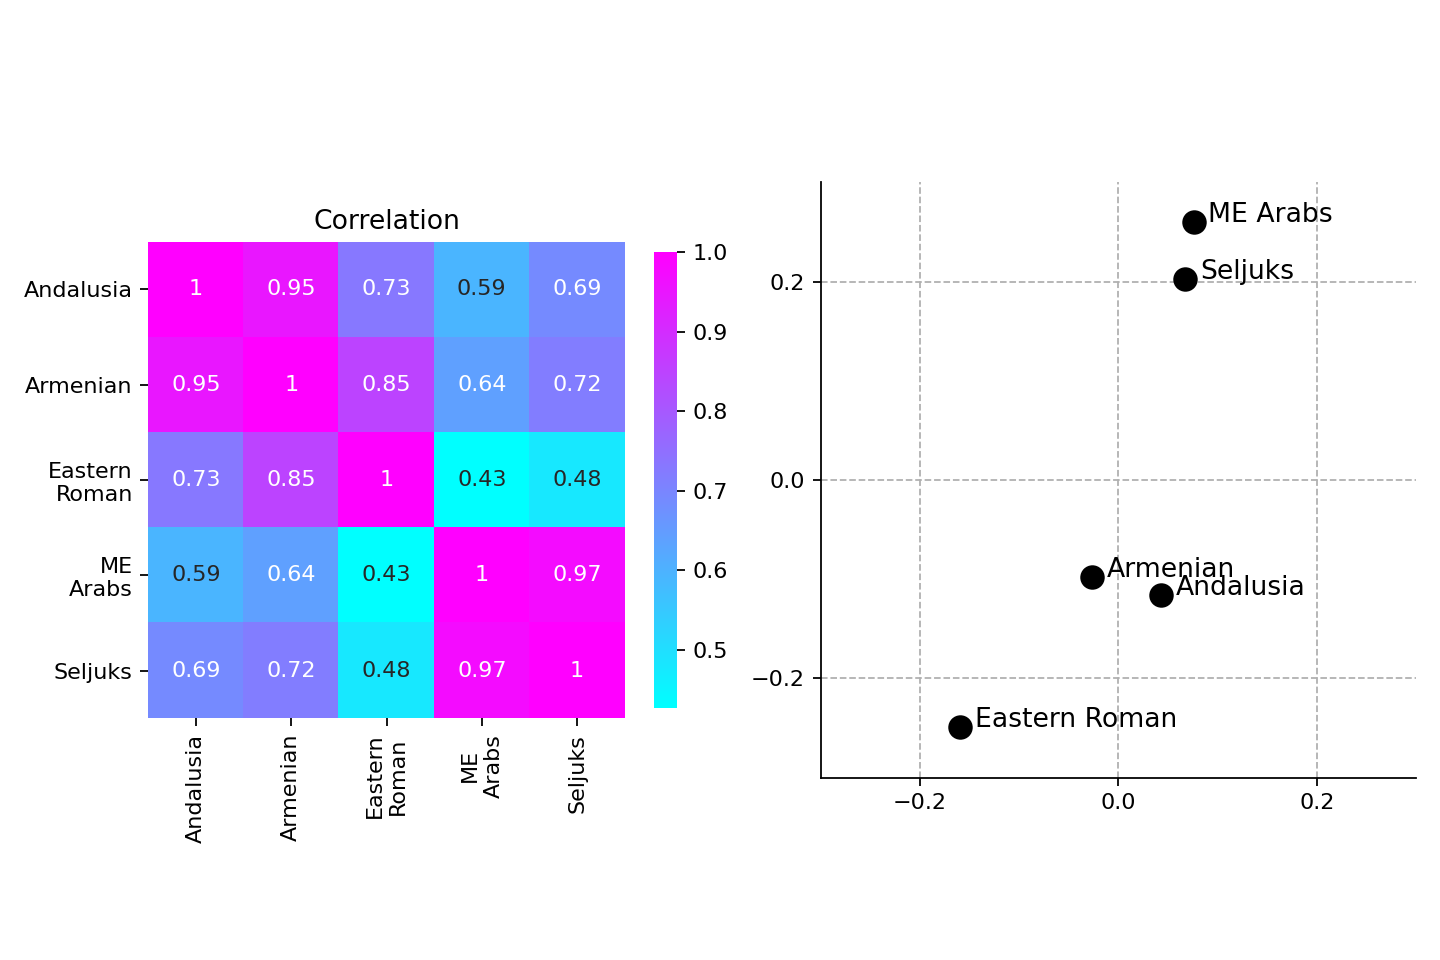

In [68]:
fig = plt.figure(figsize=(9,6))
ax  = fig.subplots(1,2)
correlation_panel(df,ax=ax[0])
MDS_panel(ax[1])
plt.tight_layout()

# Linear Regression

<IPython.core.display.Javascript object>


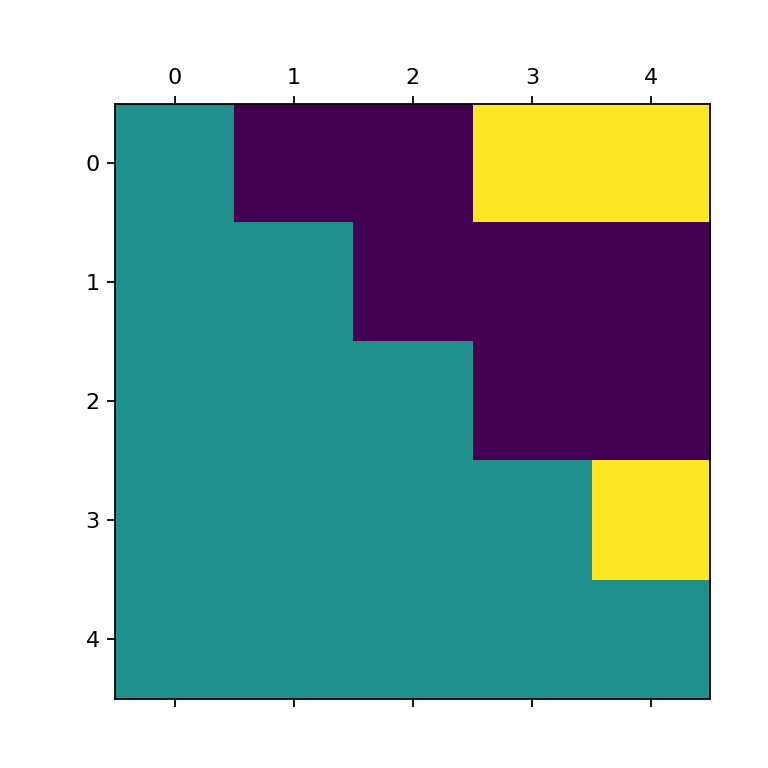

In [102]:
# Religious similarity matrix
Religion = -np.ones((5,5))

Religion[0,0] = 1
Religion[0,3] = 1
Religion[0,4] = 1
Religion[3,0] = 1
Religion[4,0] = 1
Religion[4,3] = 1
Religion[3,4] = 1

i = np.triu_indices(5,k=1)
Religion[i]
plt.matshow(np.triu(Religion,1))

<IPython.core.display.Javascript object>


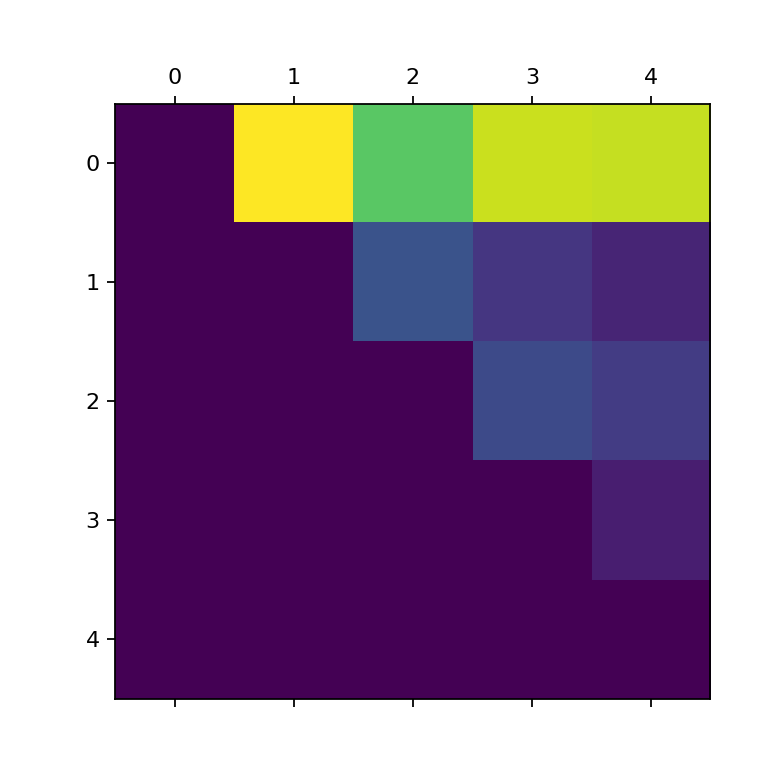

In [103]:
plt.matshow(np.triu(Distance,1))

<IPython.core.display.Javascript object>


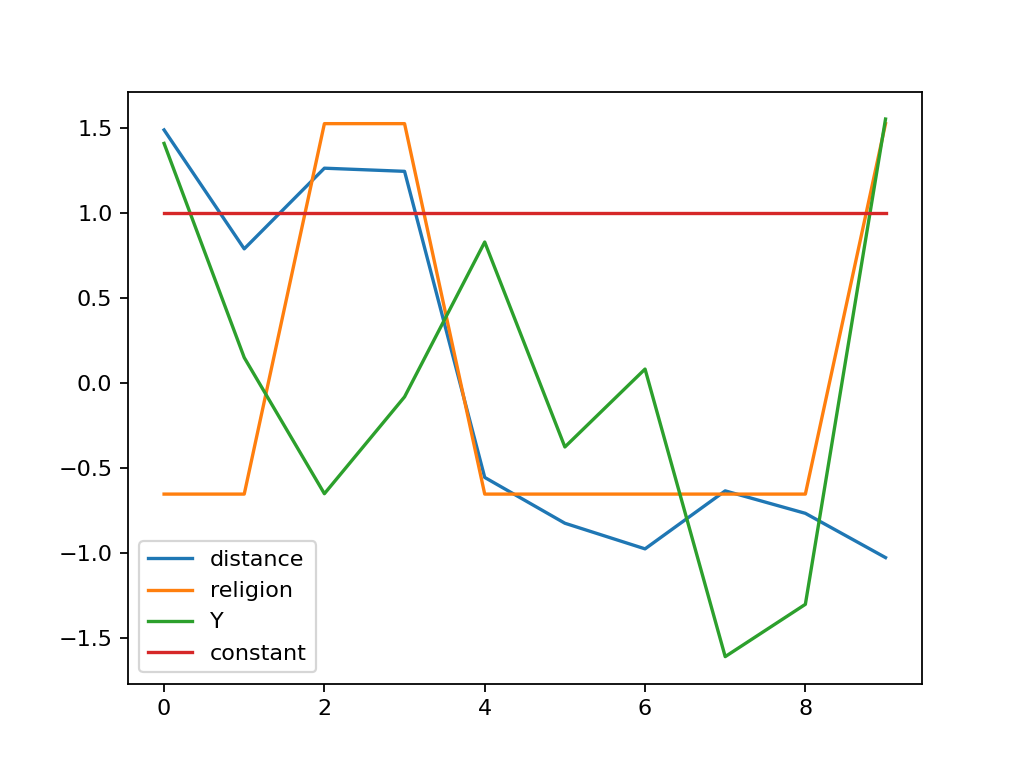

In [121]:
sim             = pd.DataFrame()
sim["distance"] = Distance[i]
sim["religion"] = Religion[i]
sim["Y"]        = symm_df.corr().values[i]

from scipy.stats import zscore
sim =  sim.apply(zscore)
sim["constant"] = 1
sim.plot()

In [122]:
import statsmodels.api as sm


X = sim[['distance','religion','constant']]
y = sim["Y"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/Users/sonat/Documents/repos/ornament_symmgroups/.env/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                 -0.233
Method:                 Least Squares   F-statistic:                    0.1509
Date:                Sun, 12 Jul 2020   Prob (F-statistic):              0.863
Time:                        17:24:41   Log-Likelihood:                -13.978
No. Observations:                  10   AIC:                             33.96
Df Residuals:                       7   BIC:                             34.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       0.1018      0.391      0.260      0.802      -0.823       1.027
religion       0.1461      0.391      0.374      0.720      -0.779       1.071
constant   -3.053e-16      0.370  -8.25e-16      1.000      -0.875       0.875
==============================================================================
Omnibus:                        1.332   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.514   Jarque-Bera (JB):                0.709
Skew:                           0.087   Prob(JB):                        0.702
Kurtosis:                       1.707   Cond. No.                         1.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Haritalar

In [22]:
df = pd.read_excel("./GeoList.xlsx",index_col=None,header=1)
df = df.reset_index(drop=True)
df = df.iloc[:,:5]
df.head(3)

,Andalusia Arabs,ME Arabs,Eastern Roman,Armenian,Seljuks
0,Cordoba,Bagdat,Venice,Yerevan,"Birgi, Turkey"
1,Granada,Cairo,NaN,NaN,"Akhan, Turkey"
2,Sevilla,Damascus,NaN,NaN,"Egridir, Turkey"


In [24]:
@memory.cache
def name_to_coor(name):
    if name is np.nan:
        lat,lon = (None,None)
        return lat,lon
    geolocator = Nominatim(user_agent="bla",timeout=10)
    location = geolocator.geocode(name)
    if not location is None:
        lat,lon = location.latitude,location.longitude
    else:
        lat,lon = None,None
    return lat,lon

for colname in ["Seljuks","Eastern Roman","ME Arabs", "Armenian","Andalusia Arabs"]:
    print(colname)
    df[colname + "_coor_lat"],df[colname + "_coor_long"] = zip(*df[colname].apply(name_to_coor))

df.head(4)

Seljuks
Eastern Roman
ME Arabs
Armenian
Andalusia Arabs


,Andalusia Arabs,ME Arabs,Eastern Roman,Armenian,Seljuks,Seljuks_coor_lat,Seljuks_coor_long,Eastern Roman_coor_lat,Eastern Roman_coor_long,ME Arabs_coor_lat,ME Arabs_coor_long,Armenian_coor_lat,Armenian_coor_long,Andalusia Arabs_coor_lat,Andalusia Arabs_coor_long
0,Cordoba,Bagdat,Venice,Yerevan,"Birgi, Turkey",38.2546,28.0654,45.4372,12.3346,33.3024,44.3788,40.1776,44.5126,37.8846,-4.77601
1,Granada,Cairo,NaN,NaN,"Akhan, Turkey",37.8137,29.1425,None,None,30.0488,31.2437,None,None,12.136,-61.6904
2,Sevilla,Damascus,NaN,NaN,"Egridir, Turkey",37.8741,30.849,None,None,33.5131,36.3096,None,None,37.3886,-5.99534
3,Valencia,Aleppo,NaN,NaN,"Incir han, Turkey",37.4788,30.5333,None,None,36.1992,37.1637,None,None,39.4697,-0.376335


In [29]:
#create a map
center_lat = df["Seljuks_coor_lat"].median()
center_lon = df["Seljuks_coor_long"].median()
this_map = folium.Map(prefer_canvas=True,location=[center_lat,center_lon],zoom_start = 3)
folium.TileLayer('stamenwatercolor').add_to(this_map)

def plotDot(lat,lon,color):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    
    for lat_,lon_ in zip(lat,lon):
        if not lat_ is None:
            folium.CircleMarker(location=[lat_,lon_],
                            radius=7,
                            weight=2,
                            color=color,
                            fill=True).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
plotDot(df["Seljuks_coor_lat"],df["Seljuks_coor_long"],color='red')
plotDot(df["Eastern Roman_coor_lat"],df["Eastern Roman_coor_long"],color='black')
plotDot(df["Armenian_coor_lat"],df["Armenian_coor_long"],color='green')
plotDot(df["ME Arabs_coor_lat"],df["ME Arabs_coor_long"],color='blue')
plotDot(df["Andalusia Arabs_coor_lat"],df["Andalusia Arabs_coor_long"],color='yellow')


this_map

# Time Diagram

In [264]:
next = 50
thick = 30
df = pd.DataFrame.from_dict({"Armenia" : [0,800,0+thick,1200],
                             "Seljuks":[0+next,1200,0+next+thick,1500],
                             "Eastern Roman" : [0+next*2,800,0+next*2+thick,1500],
                             "Moslem Arabs": [0+next*3,900,0+next*3+thick,1200]})
df

,Armenia,Seljuks,Eastern Roman,Moslem Arabs
0,0,50,100,150
1,800,1200,800,900
2,30,80,130,180
3,1200,1500,1500,1200


<IPython.core.display.Javascript object>


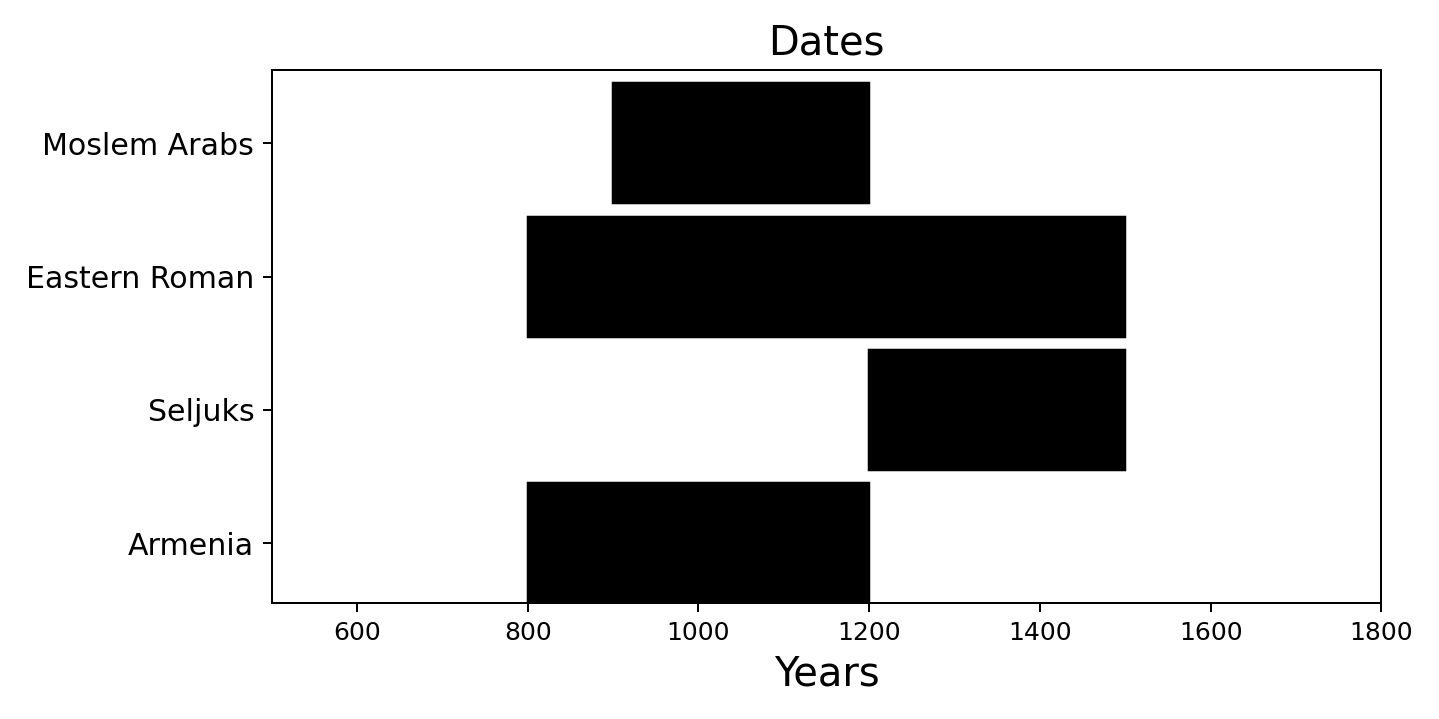

[   0  800   30 1200]
[  50 1200   80 1500]
[ 100  800  130 1500]
[ 150  900  180 1200]


In [296]:
import matplotlib.patches as patches
fig,ax = plt.subplots(1,figsize=(8,4))
# Create a Rectangle patch
for cols in df.columns:
    val = df[cols].values
    print(val)
    rect = patches.Rectangle((val[1],val[0]),val[3]-val[1],45,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)


plt.show()
# plt.tight_layout()
ax.set_xlim(500,1800)
ax.set_ylim(0,200)
ax.set_yticks(np.array([0,50,100,150])+22.5)
ax.set_yticklabels(df.columns,fontsize=12)
ax.set_xlabel('Years',fontsize=16)
ax.set_title('Dates',fontsize=16)
plt.tight_layout()
